# Residual Networks



In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import h5py
%matplotlib inline
from matplotlib import pyplot as plt

## Identity block

[![](https://mermaid.ink/img/eyJjb2RlIjoiZmxvd2NoYXJ0IExSXG5zdWJncmFwaCBCTE9DSzFbMSoxXVxuICAgIGRpcmVjdGlvbiBMUlxuICAgIEExW0NPTlYyRF0gLS0-IEIxW0JhdGNoTm9ybV1cbmVuZFxuc3ViZ3JhcGggQkxPQ0syWzMqM11cbiAgICBkaXJlY3Rpb24gTFJcbiAgICBBMltDT05WMkRdIC0tPiBCMltCYXRjaE5vcm1dXG5lbmRcbnN1YmdyYXBoIEJMT0NLM1sxKjFdXG4gICAgZGlyZWN0aW9uIExSXG4gICAgQTNbQ09OVjJEXSAtLT4gQjNbQmF0Y2hOb3JtXSBcbmVuZFxuSW5wdXQgLS0-IEJMT0NLMSAtLT4gQzFbUmVMVV0gLS0-IEJMT0NLMiAtLT4gQzJbUmVMVV0gLS0-IEJMT0NLMy0tPiBQKCgrKSktLT5DM1tSZUxVXS0tPiBPdXRwdXRcbklucHV0IC0tIHNob3J0Y3V0IC0tPiBQXG5cblxuICAgICIsIm1lcm1haWQiOnsidGhlbWUiOiJkZWZhdWx0In0sInVwZGF0ZUVkaXRvciI6ZmFsc2UsImF1dG9TeW5jIjp0cnVlLCJ1cGRhdGVEaWFncmFtIjpmYWxzZX0)](https://mermaid.live/edit#eyJjb2RlIjoiZmxvd2NoYXJ0IExSXG5zdWJncmFwaCBCTE9DSzFbMSoxXVxuICAgIGRpcmVjdGlvbiBMUlxuICAgIEExW0NPTlYyRF0gLS0-IEIxW0JhdGNoTm9ybV1cbmVuZFxuc3ViZ3JhcGggQkxPQ0syWzMqM11cbiAgICBkaXJlY3Rpb24gTFJcbiAgICBBMltDT05WMkRdIC0tPiBCMltCYXRjaE5vcm1dXG5lbmRcbnN1YmdyYXBoIEJMT0NLM1sxKjFdXG4gICAgZGlyZWN0aW9uIExSXG4gICAgQTNbQ09OVjJEXSAtLT4gQjNbQmF0Y2hOb3JtXSBcbmVuZFxuSW5wdXQgLS0-IEJMT0NLMSAtLT4gQzFbUmVMVV0gLS0-IEJMT0NLMiAtLT4gQzJbUmVMVV0gLS0-IEJMT0NLMy0tPiBQKCgrKSktLT5DM1tSZUxVXS0tPiBPdXRwdXRcbklucHV0IC0tIHNob3J0Y3V0IC0tPiBQXG5cblxuICAgICIsIm1lcm1haWQiOiJ7XG4gIFwidGhlbWVcIjogXCJkZWZhdWx0XCJcbn0iLCJ1cGRhdGVFZGl0b3IiOmZhbHNlLCJhdXRvU3luYyI6dHJ1ZSwidXBkYXRlRGlhZ3JhbSI6ZmFsc2V9)

In [2]:
def identity_block(X,filter_list, training=True):
    f1, f2, f3 = filter_list
    X_shortcut = X
    
    X = Conv2D(filters=f1, kernel_size=1, strides=1, padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=f2, kernel_size=3, strides=1, padding='same')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=f3, kernel_size=1, strides=1, padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Convolutional block

[![](https://mermaid.ink/img/eyJjb2RlIjoiZmxvd2NoYXJ0IExSXG5zdWJncmFwaCBCTE9DSzFbMSoxXVxuICAgIGRpcmVjdGlvbiBMUlxuICAgIEExW0NPTlYyRF0gLS0-IEIxW0JhdGNoTm9ybV1cbmVuZFxuc3ViZ3JhcGggQkxPQ0syWzMqM11cbiAgICBkaXJlY3Rpb24gTFJcbiAgICBBMltDT05WMkRdIC0tPiBCMltCYXRjaE5vcm1dXG5lbmRcbnN1YmdyYXBoIEJMT0NLM1sxKjFdXG4gICAgZGlyZWN0aW9uIExSXG4gICAgQTNbQ09OVjJEXSAtLT4gQjNbQmF0Y2hOb3JtXSBcbmVuZFxuc3ViZ3JhcGggU0Nbc2hvcnRjdXRdXG4gICAgZGlyZWN0aW9uIExSXG4gICAgQTRbQ09OVjJEXSAtLT4gQjRbQmF0Y2hOb3JtXSBcbmVuZFxuSW5wdXQgLS0-IEJMT0NLMSAtLT4gQzFbUmVMVV0gLS0-IEJMT0NLMiAtLT4gQzJbUmVMVV0gLS0-IEJMT0NLMy0tPiBQKCgrKSktLT5DM1tSZUxVXS0tPiBPdXRwdXRcbklucHV0IC0tPiBTQyAtLT4gUCIsIm1lcm1haWQiOnsidGhlbWUiOiJkZWZhdWx0In0sInVwZGF0ZUVkaXRvciI6ZmFsc2UsImF1dG9TeW5jIjp0cnVlLCJ1cGRhdGVEaWFncmFtIjpmYWxzZX0)](https://mermaid.live/edit#eyJjb2RlIjoiZmxvd2NoYXJ0IExSXG5zdWJncmFwaCBCTE9DSzFbMSoxXVxuICAgIGRpcmVjdGlvbiBMUlxuICAgIEExW0NPTlYyRF0gLS0-IEIxW0JhdGNoTm9ybV1cbmVuZFxuc3ViZ3JhcGggQkxPQ0syWzMqM11cbiAgICBkaXJlY3Rpb24gTFJcbiAgICBBMltDT05WMkRdIC0tPiBCMltCYXRjaE5vcm1dXG5lbmRcbnN1YmdyYXBoIEJMT0NLM1sxKjFdXG4gICAgZGlyZWN0aW9uIExSXG4gICAgQTNbQ09OVjJEXSAtLT4gQjNbQmF0Y2hOb3JtXSBcbmVuZFxuc3ViZ3JhcGggU0Nbc2hvcnRjdXRdXG4gICAgZGlyZWN0aW9uIExSXG4gICAgQTRbQ09OVjJEXSAtLT4gQjRbQmF0Y2hOb3JtXSBcbmVuZFxuSW5wdXQgLS0-IEJMT0NLMSAtLT4gQzFbUmVMVV0gLS0-IEJMT0NLMiAtLT4gQzJbUmVMVV0gLS0-IEJMT0NLMy0tPiBQKCgrKSktLT5DM1tSZUxVXS0tPiBPdXRwdXRcbklucHV0IC0tPiBTQyAtLT4gUCIsIm1lcm1haWQiOiJ7XG4gIFwidGhlbWVcIjogXCJkZWZhdWx0XCJcbn0iLCJ1cGRhdGVFZGl0b3IiOmZhbHNlLCJhdXRvU3luYyI6dHJ1ZSwidXBkYXRlRGlhZ3JhbSI6ZmFsc2V9)

In [3]:
def convolutional_block(X,filter_list,strides,training=True):
    f1, f2, f3 = filter_list
    X_shortcut = X
    
    X = Conv2D(filters=f1, kernel_size=1, strides=strides, padding='valid')(X) # s=2 for Downsampling
    X = BatchNormalization(axis = 3)(X, training=training) 
    X = Activation('relu')(X)
    
    X = Conv2D(filters=f2, kernel_size=3, strides=1, padding='same')(X)
    X = BatchNormalization(axis = 3)(X, training=training) 
    X = Activation('relu')(X)
    
    X = Conv2D(filters=f3, kernel_size=1, strides=1, padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training=training) 
    
    X_shortcut = Conv2D(filters=f3, kernel_size=1, strides=strides, padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training) 
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

## ResNet50 Model

<table>
   <tr>
      <td bgcolor="#FFFACD">Layer name</td>
      <td bgcolor="#E0FFFF">ResNet50 in paper</td>
      <td bgcolor="#FFF0F5">ResNet50 in this notebook</td>
      <td bgcolor="#F8F8FF"><center>Comment</center></td>
   </tr>
   <tr>
      <td bgcolor="#FFFFF0">conv1</td>
      <td colspan="2" bgcolor="	#E6E6FA"><center>7×7, 64, stride 2</center></td>
      <td bgcolor="#F5F5F5"></td>
   </tr>
   <tr>
       <td colspan="3" bgcolor="#F0FFF0"><center>3×3 max pool, stride 2</center></td>
       <td bgcolor="#F8F8FF"></td>
   </tr> 
    
   <tr>
      <td rowspan="2" bgcolor="#FFFACD">conv2</td>
      <td rowspan="2" bgcolor="#E0FFFF"><center>Identity block × 3</center></td>
      <td bgcolor="#FFF0F5">Convolutional block × 1</td>
      <td rowspan="2" bgcolor="#F5F5F5">filters = [64, 64, 256]</td>
   </tr>
   <tr>
      <td bgcolor="#FFF0F5"><center>Identity block × 2</center></td>
   </tr>
   <tr>
      <td rowspan="2" bgcolor="#FFFFF0">conv3</td>
      <td rowspan="2" bgcolor="#F0FFFF"><center>Identity block × 4</center></td>
      <td bgcolor="#FFFAFA">Convolutional block × 1</td>
      <td bgcolor="#F8F8FF">filters = [128, 128, 512]</td>
   </tr>
   <tr>
      <td bgcolor="#FFFAFA">Identity block × 3</td>
      <td bgcolor="#F8F8FF">Down sampling in conv3-1, stride 2</td>
   </tr>
   <tr>
      <td rowspan="2" bgcolor="#FFFACD">conv4</td>
      <td rowspan="2" bgcolor="#E0FFFF"><center>Identity block × 6</center></td>
      <td bgcolor="#FFF0F5">Convolutional block × 1</td>
      <td bgcolor="#F5F5F5">filters = [256, 256, 1024]</td>
   </tr>
   <tr>
      <td bgcolor="#FFF0F5">Identity block × 5</td>
      <td bgcolor="#F5F5F5">Down sampling in conv4-1, stride 2</td>
   </tr>
   <tr>
      <td rowspan="2" bgcolor="#FFFFF0">conv5</td>
      <td rowspan="2" bgcolor="#F0FFFF"><center>Identity block × 3</center></td>
      <td bgcolor="#FFFAFA">Convolutional block × 1</td>
      <td bgcolor="#F8F8FF">filters = [512, 512, 2048]</td>
   </tr>
   <tr>
      <td bgcolor="#FFFAFA">Identity block × 2</td>
      <td bgcolor="#F8F8FF">Down sampling in conv5-1, stride 2</td>
   </tr>
   <tr>
      <td colspan="3" bgcolor="#F0FFF0"><center>2×2 average pool</center></td>
       <td bgcolor="#F5F5F5">stride 2</td>
   </tr>
   <tr>
      <td colspan="3" bgcolor="	#E6E6FA"><center>Flatten</center></td>
       <td bgcolor="#F8F8FF"></td>
   </tr>
   <tr>
      <td colspan="3" bgcolor="#7FFFD4"><center>Fully connected, softmax</center></td>
       <td bgcolor="#F5F5F5"></td>
   </tr>
</table>

In [4]:
def ResNet50(input_shape, classes):
    X_input = Input(input_shape)
    # conv1
    X = Conv2D(filters = 64, kernel_size = 7, strides = 2)(X_input)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    # conv2
    X = convolutional_block(X, filter_list=[64, 64, 256], strides=1)
    for i in range(2):
        X = identity_block(X, filter_list=[64, 64, 256])
    # conv3
    X = convolutional_block(X, filter_list=[128, 128, 512], strides=2)
    for i in range(3):
        X = identity_block(X, filter_list=[128, 128, 512])
    # conv4
    X = convolutional_block(X, filter_list=[256, 256, 1024], strides=2)
    for i in range(5):
        X = identity_block(X, filter_list=[256, 256, 1024],)
    # conv5
    X = convolutional_block(X, filter_list=[512, 512, 2048], strides=2)
    for i in range(2):
        X = identity_block(X, filter_list=[512, 512, 2048])
    X = AveragePooling2D(pool_size=2, strides=2)(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)
    # Model
    model = Model(inputs = X_input, outputs = X)

    return model

In [5]:
model = ResNet50(input_shape = (64, 64, 3), classes = 2)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 29, 29, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 29, 29, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 29, 29, 64)   0           ['batch_normalization[0][0]']

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Load dataset

In [7]:
def load_dataset(file_path,file_name):
    dataset = h5py.File(file_path+"\\"+file_name, "r")
    X = np.array(dataset["X"][:])
    y = np.array(dataset["y"][:])
    classes = np.array(dataset["list_classes"][:])
    
    return X,y,classes

In [8]:
target_file_path = "datasets\\dogsvcats"
train_file_name = "dogvcat64_train.h5"
test_file_name = "dogvcat64_test.h5"

train_X_orig, train_y_orig, classes = load_dataset(target_file_path, train_file_name)
test_X_orig, test_y_orig, _ = load_dataset(target_file_path, test_file_name)

This is a cat


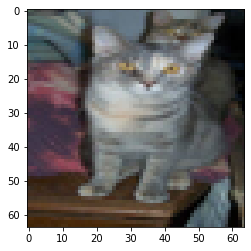

In [27]:
n = 0
print("This is a", classes[train_y_orig[n]].decode('UTF-8'))
plt.imshow(train_X_orig[n])

This is a dog


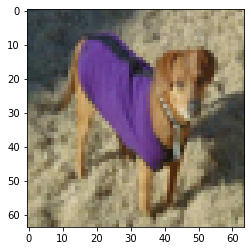

In [28]:
n = 10
print("This is a", classes[train_y_orig[n]].decode('UTF-8'))
plt.imshow(train_X_orig[n])

In [9]:
X_train = train_X_orig / 255.
X_test = test_X_orig / 255.
Y_train = np.eye(2)[train_y_orig]
Y_test = np.eye(2)[test_y_orig]

In [10]:
print("Train set X shape is", X_train.shape)
print("Train set Y shape is", Y_train.shape)
print("Test set X shape is", X_test.shape)
print("Test set Y shape is", Y_test.shape)

Train set X shape is (1360, 64, 64, 3)
Train set Y shape is (1360, 2)
Test set X shape is (102, 64, 64, 3)
Test set Y shape is (102, 2)


In [11]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
43/43 [==============================] - 64s 1s/step - loss: 1.3608 - accuracy: 0.5257
Epoch 2/10
43/43 [==============================] - 59s 1s/step - loss: 0.6959 - accuracy: 0.6559
Epoch 3/10
43/43 [==============================] - 59s 1s/step - loss: 0.5002 - accuracy: 0.7676
Epoch 4/10
43/43 [==============================] - 59s 1s/step - loss: 0.4318 - accuracy: 0.8228
Epoch 5/10
43/43 [==============================] - 59s 1s/step - loss: 0.4362 - accuracy: 0.8360
Epoch 6/10
43/43 [==============================] - 61s 1s/step - loss: 0.4559 - accuracy: 0.8309
Epoch 7/10
43/43 [==============================] - 65s 2s/step - loss: 0.2197 - accuracy: 0.9228
Epoch 8/10
43/43 [==============================] - 85s 2s/step - loss: 0.2127 - accuracy: 0.9162
Epoch 9/10
43/43 [==============================] - 73s 2s/step - loss: 0.3816 - accuracy: 0.8706
Epoch 10/10
43/43 [==============================] - 67s 2s/step - loss: 0.2424 - accuracy: 0.9096


In [13]:
preds = model.evaluate(X_test, Y_test)

4/4 [==============================] - 1s 155ms/step - loss: 0.9784 - accuracy: 0.6471
